In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '20'

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
import time
from tensorflow import keras

tf.config.optimizer.set_jit(True)
print('tensorflow', tf.__version__)

tensorflow 2.17.0


## Creating the dataset
### Loading data

In [2]:
train_dir = './temp/train/'
valid_dir = './temp/validation/'

def get_id_img(directory):
    res = {}
    for identity in os.listdir(directory):
        temp_dir = os.path.join(directory, identity)
        lst = []
        for img_path in os.listdir(temp_dir):
            lst.append(os.path.join(directory, identity, img_path))
        res[int(identity)] = lst
        
    return res

train_data = get_id_img(train_dir)
valid_data = get_id_img(valid_dir)

### Creating triplet dataset

In [3]:
def get_triplet_dataset(data):
    res = []
    cnt = 0
    num_classes = len(data)
    min_class = min(data.keys())
    for identity in data.keys():
        id_images = data[identity]
        for i in range(len(id_images) - 1):
            # Anchor image
            anchor_path = id_images[i]
            # Take an image with the same identity for positive sample
            positive_path = id_images[i + 1]
    
            # Take an image with different identity for negative sample
            addition = np.random.randint(1, num_classes)
            negative_id = (identity + addition) % num_classes + min_class
            neg_id_images = data[negative_id]
            negative_path = neg_id_images[i]
    
            res.append([anchor_path, positive_path, negative_path])

        cnt += 1
        print(f'\r{cnt:>5} out of {len(data.keys()):>5}', end='')
    print()
    return res

print('Preparting train triplet dataset')
train_triplet = get_triplet_dataset(train_data)
print('Preparing validation triplet dataset')
valid_triplet = get_triplet_dataset(valid_data)

Preparting train triplet dataset
 2000 out of  2000
Preparing validation triplet dataset
33333 out of 33333


## Create the pipeline

In [4]:
IMAGE_SIZE = (224, 224)
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16
BUFFER_SIZE = 1000

def get_image(path):
    file = tf.io.read_file(path)
    img = tf.image.decode_png(file, channels=3)
    return img


def get_images(anchor_path, positive_path, negative_path):
    anchor = get_image(anchor_path)
    positive = get_image(positive_path)
    negative = get_image(negative_path)
    return anchor, positive, negative


def normalize(image):
    image = tf.cast(image, tf.float32)
    return preprocess_input(image)


def augment(image):
    image = tf.image.random_contrast(image, 0.9, 1.2)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0.9, 1.2)
    image = tf.clip_by_value(image, 0, 255)
    return image


def get_training_set(inputs):
    anchor_path, positive_path, negative_path = inputs[0], inputs[1], inputs[2]
    
    # Getting images
    anchor, positive, negative = get_images(anchor_path, positive_path, negative_path)

    # # Random jpeg quality is done on integer images
    # anchor = tf.image.random_jpeg_quality(anchor, 50, 100)
    # positive = tf.image.random_jpeg_quality(positive, 50, 100)
    # negative = tf.image.random_jpeg_quality(negative, 50, 100)

    # Resize the images
    anchor = tf.image.resize(anchor, IMAGE_SIZE)
    positive = tf.image.resize(positive, IMAGE_SIZE)
    negative = tf.image.resize(negative, IMAGE_SIZE)

    # do augment
    # anchor = augment(anchor)
    # positive = augment(positive)
    # negative = augment(negative)

    # normalize
    anchor = normalize(anchor)
    positive = normalize(positive)
    negative = normalize(negative)

    return anchor, positive, negative


def get_validation_set(inputs):
    anchor_path, positive_path, negative_path = inputs[0], inputs[1], inputs[2]
    
    # Getting imagestrain_triplet
    anchor, positive, negative = get_images(anchor_path, positive_path, negative_path)

    # Resize the images
    anchor = tf.image.resize(anchor, IMAGE_SIZE)
    positive = tf.image.resize(positive, IMAGE_SIZE)
    negative = tf.image.resize(negative, IMAGE_SIZE)

    # normalize
    anchor = normalize(anchor)
    positive = normalize(positive)
    negative = normalize(negative)

    return anchor, positive, negative


train_ds = tf.data.Dataset.from_tensor_slices(train_triplet)
train_ds = train_ds.map(get_training_set, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=BUFFER_SIZE)
train_ds = train_ds.batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE, drop_remainder=True)
train_ds = train_ds.shuffle(1000)
train_ds = train_ds.prefetch(AUTOTUNE)

valid_ds = tf.data.Dataset.from_tensor_slices(valid_triplet)
valid_ds = valid_ds.map(get_validation_set, num_parallel_calls=AUTOTUNE)
valid_ds = valid_ds.batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE)
valid_ds = valid_ds.prefetch(AUTOTUNE)

del train_triplet
del valid_triplet

In [ ]:
num_rows = 10
cnt = 0
plt.figure(figsize=(5, num_rows * 2))

for anc, pos, neg in train_ds.take(1):
    for i in range(num_rows):
        cnt += 1
        ax = plt.subplot(num_rows, 3, cnt)
        ax.imshow(anc[i] / 255.0)
        ax.axis('off')
        ax.set_title('Anchor')

        cnt += 1
        ax = plt.subplot(num_rows, 3, cnt)
        ax.imshow(pos[i] / 255.0)
        ax.axis('off')
        ax.set_title('Positive')

        cnt += 1
        ax = plt.subplot(num_rows, 3, cnt)
        ax.imshow(neg[i] / 255.0)
        ax.axis('off')
        ax.set_title('Negative')

## Create the model

In [6]:
from keras.layers import Dropout, Input, GlobalAveragePooling2D, Layer, Dense, Flatten, BatchNormalization, Activation, Lambda
from keras.models import Model

In [7]:
base_model = ResNet50(include_top=False, input_shape=IMAGE_SIZE + (3,))

In [8]:
for i, l in enumerate(base_model.layers):
    print(i, l.name)

0 input_layer
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_

In [9]:
class SiameseNetwork(Model):
    def __init__(self, units, dropout_rate=0.1):
        super(SiameseNetwork, self).__init__()
        
        self.base_model = ResNet50(include_top=False, input_shape=IMAGE_SIZE + (3,))

        self.avg_pool = GlobalAveragePooling2D(name='global_avg')
        self.dropout = Dropout(dropout_rate, name='dropout')
        self.encoder_output = Dense(units, name='encoder_output')
        self.norm = Lambda(lambda x: tf.linalg.l2_normalize(x, axis=-1))

    def build(self, input_shape):
        inputs = Input(shape=input_shape)
        self.call(inputs)
        self.built = True

    def call(self, inputs, training=False):
        x = self.base_model(inputs, training=training)
        x = self.avg_pool(x)
        x = self.encoder_output(x)
        x = self.norm(x)
        return x

In [10]:
siamese_net = SiameseNetwork(128)

siamese_net.base_model.trainable = True
for l in siamese_net.base_model.layers[:155]:
    l.trainable = False
    
siamese_net.build(input_shape=IMAGE_SIZE + (3,))
siamese_net.summary()

Model: "siamese_network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg                      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,849,984 (90.98 MB)

 Trainable params: 9,193,600 (35.07 MB)

 Non-trainable params: 14,656,384 (55.91 MB)

## Compile the model

In [11]:
from keras.optimizers import Adam
from keras.metrics import Metric
from keras.callbacks import ReduceLROnPlateau

### Triplet loss
Given three images to the neural-network to generate embeddings of that image we use triplet loss to optimize the network in a way to let the network recognize faces in the image.<br>
Each time ```anchor```, ```positive``` and ```negative``` images are given; ```anchor``` is the image with a face just like ```positive``` and ```negative``` is another face that is not like the other two. Using triplet loss we make the network choose vectors for ```anchor``` and ```positive``` in a way that their euclidean distance is minimized and a vector for ```negative``` in a way that its euclidean distance from ```anchor``` is maximized.

$$
\begin{align}
    d_{ap} &= \sqrt{\sum_{j}(\text{anchor}_j - \text{positive}_j)^2}\\
    d_{an} &= \sqrt{\sum_{j}(\text{anchor}_j - \text{negative}_j)^2}
\end{align}
$$

We wish to have $d_{ap} \le d_{an}$ in other words $d_{ap} - d_{an} \le 0$. However network might learn an embedding of all zeros, in that case the criteria is met and distances of $d_{ap}$ and $d_{ap}$ are $0$.<br>
Let's define a margin called ```alpha``` so that $d_{ap} - d_{an} \le -\alpha$, meaning that distance between anchor and positive is less than distance of anchor and negative by the amount of $\alpha$. 
$$
\begin{align}
    d_{ap} - d_{an} + \alpha \le 0
\end{align}
$$

In [12]:
def get_triplet_loss(alpha=0.5):
    def loss_func(anchor, positive, negative):
        d_ap = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
        d_an = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
        
        loss = tf.maximum(d_ap - d_an + alpha, 0)
        return tf.reduce_mean(loss)
    return loss_func


class TripletAccuracy(Metric):
    def __init__(self, threshold=0.5, name='triplet_metric', **kwargs):
        super(TripletAccuracy, self).__init__(name=name, **kwargs)

        self.count = self.add_weight(name='count',
                                   dtype='float32', 
                                   shape=(), 
                                   initializer='zeros')

        self.total = self.add_weight(name='total', 
                                   dtype='float32', 
                                   shape=(), 
                                   initializer='zeros')
        self.threshold = threshold


    def update_state(self, anchor, positive, negative):
        # Computes similarity for Anchor and Positive
        similarity = tf.reduce_sum(anchor * positive, axis=-1)
        similarity = similarity / (tf.linalg.norm(anchor, axis=-1) * tf.linalg.norm(positive, axis=-1))
        
        matches = tf.reduce_sum(tf.cast(similarity >= self.threshold, tf.float32))
        self.count.assign_add(matches)

        # Computes similarity for Anchor and Negative
        similarity = tf.reduce_sum(anchor * negative, axis=-1)
        similarity = similarity / (tf.linalg.norm(anchor, axis=-1) * tf.linalg.norm(negative, axis=-1))
        
        matches = tf.reduce_sum(tf.cast(similarity < self.threshold, tf.float32))
        self.count.assign_add(matches)

        # Add total
        self.total.assign_add(tf.cast(tf.shape(anchor)[0] * 2, dtype=tf.float32))


    def result(self):
        return self.count / self.total if self.total > 0.0 else 0.0


    def reset_states(self):
        self.total.assign(0.0)
        self.count.assign(0.0)
        

ALPHA = 1.0
triplet_loss = get_triplet_loss(ALPHA)
train_acc = TripletAccuracy(threshold=0.5)
valid_acc = TripletAccuracy(threshold=0.5)
optimizer = Adam()

In [13]:
@tf.function
def training_step(anchor, positive, negative):
    loss = 0
    with tf.GradientTape() as tape:
        a = siamese_net(anchor, training=True)
        p = siamese_net(positive, training=True)
        n = siamese_net(negative, training=True)
        loss = triplet_loss(a, p, n)
        
    train_acc.update_state(a, p, n)
    variables = siamese_net.trainable_variables
    grads = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(grads, variables))
    return loss

In [14]:
@tf.function
def validation_step(anchor, positive, negative):
    a = siamese_net(anchor, training=False)
    p = siamese_net(positive, training=False)
    n = siamese_net(negative, training=False)
    loss = triplet_loss(a, p, n)
    valid_acc.update_state(a, p, n)
    return loss

In [15]:
def get_scheduler(initial_learning_rate, min_learning_rate=1e-5, weight=0.9):
    def func(epoch):
        return max(initial_learning_rate * weight ** epoch, min_learning_rate)
    return func

scheduler = get_scheduler(1e-2, weight=0.9)

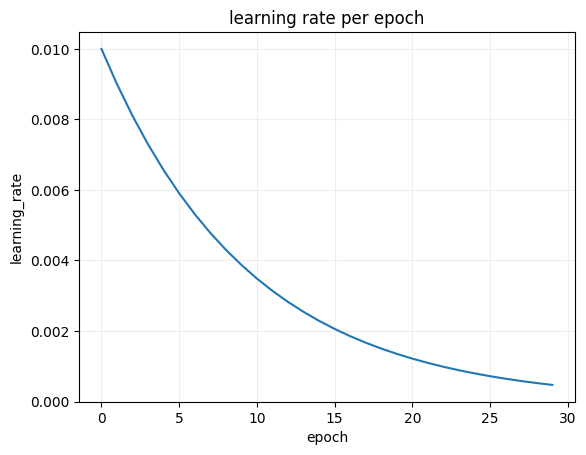

In [16]:
plt.figure()
ax = plt.subplot(111)
ax.plot([x for x in range(30)], [scheduler(x) for x in range(30)]);
ax.set_title('learning rate per epoch');
ax.set_xlabel('epoch')
ax.set_ylabel('learning_rate');
ax.grid(c='#eee');

In [17]:
def train(epochs=10, learning_rate_scheduler=None):
    train_loss_hist = []
    valid_loss_hist = []
    train_acc_hist = []
    valid_acc_hist = []

    for epoch in range(epochs):
        train_acc.reset_states()
        valid_acc.reset_states()
        start = time.time()
        train_mean_loss = 0
        valid_mean_loss = 0
        optimizer.learning_rate = scheduler(epoch)
        print(f'Epoch {epoch + 1:>3}')

        for step, (anchor, positive, negative) in enumerate(train_ds):
            loss = training_step(anchor, positive, negative)
            acc = train_acc.result()
            train_mean_loss = train_mean_loss + (1 / (step + 1)) * (loss - train_mean_loss)
            end = time.time()
            print(f'\r{int(end - start):>3} seconds | Step {step:>4}\tloss: {train_mean_loss:>4.4f}\taccuracy: {acc:>.3f}', end='')
        print()
        
        train_loss_hist.append(train_mean_loss)
        train_acc_hist.append(acc)

        for step, (anchor, positive, negative) in enumerate(valid_ds):
            loss = validation_step(anchor, positive, negative)
            acc = valid_acc.result()
            valid_mean_loss = valid_mean_loss + (1 / (step + 1)) * (loss - valid_mean_loss)

            end = time.time()
            print(f'\r{int(end - start):>3} seconds | Step {step:>4}\tloss: {valid_mean_loss:>4.4f}\taccuracy: {acc:>.3f}', end='')
        print()

        valid_loss_hist.append(valid_mean_loss)
        valid_acc_hist.append(acc)
        

    return {'epochs':list(range(0, epochs)), 
            'loss':train_loss_hist, 
            'acc':train_acc_hist, 
            'val_loss':valid_loss_hist, 
            'val_acc':valid_acc_hist}

In [18]:
history = train(epochs=5)

Epoch   1


I0000 00:00:1721102522.651613    7467 service.cc:146] XLA service 0x74d0b4003000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721102522.652143    7467 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
I0000 00:00:1721102522.928735    7467 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1743 seconds | Step 8874	loss: 0.2062	accuracy: 0.862
2697 seconds | Step 8333	loss: 0.0980	accuracy: 0.929
Epoch   2
1701 seconds | Step 8874	loss: 0.1303	accuracy: 0.905
2638 seconds | Step 8333	loss: 0.0773	accuracy: 0.945
Epoch   3
1715 seconds | Step 8874	loss: 0.0999	accuracy: 0.923
2648 seconds | Step 8333	loss: 0.0747	accuracy: 0.947
Epoch   4
1757 seconds | Step 8874	loss: 0.0777	accuracy: 0.936
2700 seconds | Step 8333	loss: 0.0694	accuracy: 0.950
Epoch   5
1795 seconds | Step 8874	loss: 0.0596	accuracy: 0.949
2727 seconds | Step 8333	loss: 0.0661	accuracy: 0.955


## Fine-Tuning

In [86]:
FREEZE_UP_TO = 143

siamese_net.base_model.trainable = True

for i in range(FREEZE_UP_TO):
    siamese_net.base_model.layers[i].trainable = False

siamese_net.summary()

Model: "siamese_network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg                      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,849,984 (90.98 MB)

 Trainable params: 9,193,600 (35.07 MB)

 Non-trainable params: 14,656,384 (55.91 MB)

In [87]:
optimizer.learning_rate = 1e-4
fine_tune_history = train(epochs=1)

Epoch   1
1715 seconds | Step 8874	loss: 0.0563	accuracy: 0.953
2647 seconds | Step 8333	loss: 0.0707	accuracy: 0.951


## Evaluation

In [88]:
def plot(history, fine_tune_history, key, ax):
    epochs = history['epochs']
    train_key = history[key]
    val_key = history['val_' + key]

    fine_tune_epochs = [x + len(epochs) for x in fine_tune_history['epochs']]
    fine_train_key = fine_tune_history[key]
    fine_val_key = fine_tune_history['val_' + key]

    ax.plot(epochs + fine_tune_epochs, train_key + fine_train_key, label='train_' + key)
    ax.plot(epochs + fine_tune_epochs, val_key + fine_val_key, label='val_' + key)
    ax.axvline(x=fine_tune_epochs[0], c='red', label='fine_tune')
    ax.grid(c='#eee')
    ax.set_title(f'{key.capitalize()} per epoch')
    ax.set_xlabel('x')
    ax.set_ylabel(f'{key}')
    return ax

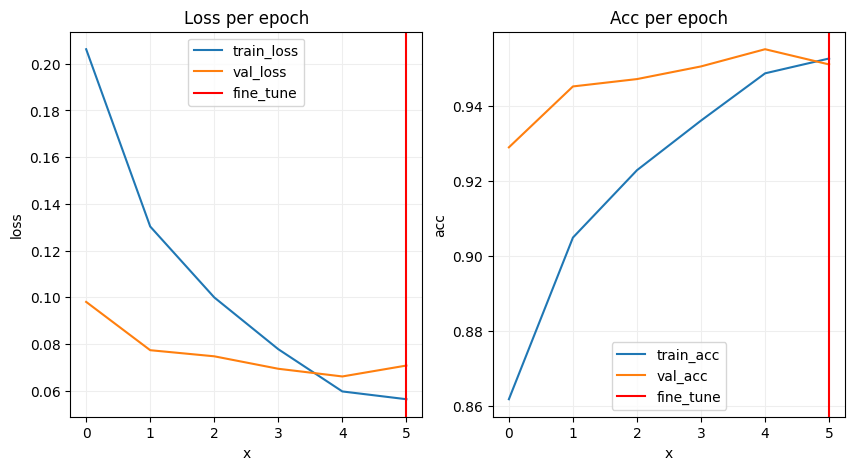

In [89]:
plt.figure(figsize=(10, 5))

ax = plt.subplot(1, 2, 1)
ax = plot(history, fine_tune_history, 'loss', ax)
ax.legend();

ax = plt.subplot(1, 2, 2)
ax = plot(history, fine_tune_history, 'acc', ax)
ax.legend();

## Save the model

In [119]:
class FaceRecognizer(tf.Module):
    def __init__(self, siamese_net, preprocess_input):
        super(FaceRecognizer, self).__init__()
        self.siamese_net = siamese_net
        self.preprocess_input = preprocess_input

    @tf.function(input_signature=[tf.TensorSpec(shape=(None, ) + IMAGE_SIZE + (3,), dtype=tf.float32), 
                                  tf.TensorSpec(shape=(None, ) + IMAGE_SIZE + (3,), dtype=tf.float32)])
    def __call__(self, anchor, image):
        anchor = tf.cast(anchor, tf.float32)
        image = tf.cast(image, tf.float32)
        anchor = preprocess_input(anchor)
        image = preprocess_input(image)
        anchor = self.siamese_net(anchor, training=False)
        image = self.siamese_net(image, training=False)
        similarity = tf.linalg.norm(anchor - image, axis=-1)
        return similarity

In [120]:
recognizer = FaceRecognizer(siamese_net, preprocess_input)

In [121]:
anchor = cv2.imread('./temp/b1.jpg')
anchor = cv2.cvtColor(anchor, cv2.COLOR_BGR2RGB)
anchor = cv2.resize(anchor, IMAGE_SIZE)

positive = cv2.imread('./temp/b2.jpg')
positive = cv2.cvtColor(positive, cv2.COLOR_BGR2RGB)
positive = cv2.resize(positive, IMAGE_SIZE)

negative = cv2.imread('./temp/not_me.jpg')
negative = cv2.cvtColor(negative, cv2.COLOR_BGR2RGB)
negative = cv2.resize(negative, IMAGE_SIZE)

In [125]:
print("Value of 0.0 means the images are the same")
print('ME:', recognizer(anchor[tf.newaxis], positive[tf.newaxis]).numpy().flatten()[0])
print('NOT ME:', recognizer(anchor[tf.newaxis], negative[tf.newaxis]).numpy().flatten()[0])

Value of 0.0 means the images are the same
ME: 0.4674794
NOT ME: 1.2639263


In [126]:
siamese_net.save('./models/siamese_net_v1.keras')